# PySAD - MedianAbsoluteDeviation

## Carga de datos

Cargamos librerías y datos:

Las típicas (pandas, matplotlib, numpy)...

Funciones de sklearn de preprocesado y métricas.

Modelos y métricas de PyOD.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from time import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import cohen_kappa_score

from pysad.models import  MedianAbsoluteDeviation
from pysad.transform.probability_calibration import ConformalProbabilityCalibrator

random_state = np.random.RandomState(42)

In [2]:
df = pd.read_csv('../../Datasets/Dataset_2.csv',index_col='fecha', usecols=['fecha','FormacionNIRHumedadPV', 'FibraticPredNIRHumedadPV','Negro', 'CurvaCola', 'Congelado', 'Hum'])
df['Diferencia'] = df['FormacionNIRHumedadPV'] - df['FibraticPredNIRHumedadPV']
df = df.drop(['FormacionNIRHumedadPV','FibraticPredNIRHumedadPV'], axis=1)
df = df.loc[:,['Diferencia','Negro', 'CurvaCola', 'Congelado', 'Hum']]
df.index = pd.to_datetime(df.index)
df.head(2)

,Diferencia,Negro,CurvaCola,Congelado,Hum
fecha,,,,,
2021-02-10 10:00:00,-6.465569,1,0,1,0
2021-02-10 10:01:00,-6.355772,1,0,1,0


Unimos todas las anomalías en una columna, para posteriormente realizar las métricas tanto para todas las anomalías como para cada una en concreto.

Para ello, sumo las columnas de anomalías, y después las que son mayores que cero las establezco como uno (porque significa que alguna de las columnas si tenía anomalía registrada), las demás como cero.

In [3]:
df['Anomalia'] = df['Negro'] + df['CurvaCola'] +  df['Congelado'] + df['Hum']
df['Anomalia'] = df['Anomalia'].map(lambda x: 1 if x!=0 else 0)

lista_anomalias = ['Negro', 'CurvaCola', 'Congelado', 'Hum','Anomalia']

atributos = df.columns.drop(lista_anomalias)
len(atributos)

1

## Escogemos un subconjunto del dataset para entrenamientos más cortos

In [4]:
#df = df.iloc[40000:60000,:]

## Proporción de cada anomalía

In [5]:
def proporciones(df,columna):
    return round(df[df[columna]==1][columna].count()/df[columna].count() *100,3)

lista_proporciones = []

for i in lista_anomalias:
    lista_proporciones.append(proporciones(df,i))


df_proporciones = np.array(lista_proporciones)
df_proporciones = pd.DataFrame(df_proporciones).T
df_proporciones.columns = lista_anomalias

print('Proporción de anomalías en %: ')
df_proporciones.head()

Proporción de anomalías en %: 


,Negro,CurvaCola,Congelado,Hum,Anomalia
0,6.652,27.758,6.333,0.547,32.823


## Preparación

Separo conjuntos de train, validation y test, y estandarizo:

Separo los atributos en X y las anomalias en Y. De esta manera, al realizar el train_test_split, se mantendrán las proporciones de cada anomalía, con muestreos temporales aleatorios.

Primero separo en train-test (80-20) y después separo el test en test-validation (50-50), para así obtener finalmente train-validation-test (80-10-10).

Una vez separado, entreno el StandardScaler() con el conjunto de entrenamiento, y se lo aplico al conjunto de validación y test.

In [6]:
#Separo los atributos para el entrenamiento de la salida
X = df.loc[:, 'Diferencia']
Y = df.loc[:, lista_anomalias]

#Calculo la proporcion de outliers presentes
proporcion_outliers = round(np.count_nonzero(Y.Anomalia) / len(Y.Anomalia),3)

#Separo entrenamiento y test (80-20)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = random_state)

## Entrenamiento

Para ello, establezco primero la lista de hiperparámetros a entrenar y la de métricas a analizar.

creo dos arrays de ceros, uno para las scores y otro para las labels.

Realizo un bucle, estableciendo un entrenamiento por cada hiperparámetro.

Después, extraigo scores y labels, almacenándolas en un array, y calculo las métricas, haciendo lo mismo. Una vez termina el bucle, estos dos vectores los paso a un dataframe para su visualización.

In [7]:
t0 = time()

#Establecemos parametros
metricas_list = ['roc_auc','accuracy','precision','kappa','sensibilidad','especificidad']
anomalia = 'Anomalia'

#Entrenamiento
clf = MedianAbsoluteDeviation()
calibrator = ConformalProbabilityCalibrator(windowed=False)

clf.fit(np.reshape(X_train.to_list(),(-1,1)))
scores_train = clf.score(np.reshape(X_train.to_list(),(-1,1)))
calibrator.fit(scores_train)

#Prediccion
test_scores = clf.score(np.reshape(X_test.to_list(),(-1,1)))
test_scores = calibrator.transform(test_scores)

t1 = time()
duration = round(t1 - t0, ndigits=4)
print('Tiempo: ', duration)

Tiempo:  112414.165


## Análisis de Scores:

Dado que PySAD no etiqueta directamente las instancias, realizamos un pequeño análisis de la score de salida de cada una para determinar el umbral adecuado:

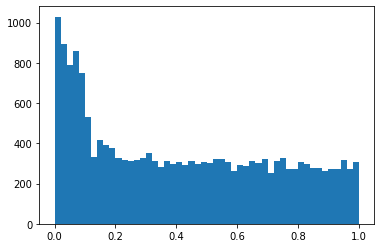

In [8]:
Y_test['scores'] = test_scores
n, bins, patches = plt.hist(Y_test[Y_test['Anomalia']==1]['scores'], bins=50)
plt.show()

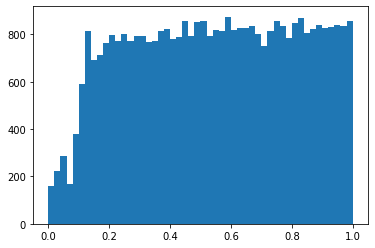

In [9]:
plt.hist(Y_test[Y_test['Anomalia']==0]['scores'], bins=50)
plt.show()

Miramos los bins:

In [10]:
bins

array([0.        , 0.01999875, 0.03999749, 0.05999624, 0.07999498,
       0.09999373, 0.11999247, 0.13999122, 0.15998997, 0.17998871,
       0.19998746, 0.2199862 , 0.23998495, 0.25998369, 0.27998244,
       0.29998119, 0.31997993, 0.33997868, 0.35997742, 0.37997617,
       0.39997491, 0.41997366, 0.43997241, 0.45997115, 0.4799699 ,
       0.49996864, 0.51996739, 0.53996613, 0.55996488, 0.57996363,
       0.59996237, 0.61996112, 0.63995986, 0.65995861, 0.67995735,
       0.6999561 , 0.71995485, 0.73995359, 0.75995234, 0.77995108,
       0.79994983, 0.81994858, 0.83994732, 0.85994607, 0.87994481,
       0.89994356, 0.9199423 , 0.93994105, 0.9599398 , 0.97993854,
       0.99993729])

Analizamos la curva roc en función del punto en que discriminemos anomalía de no anomalía:

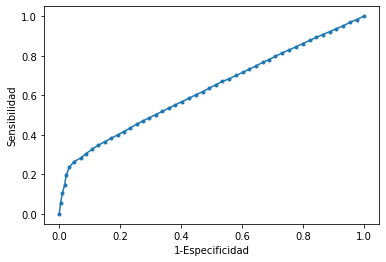

In [11]:
valores = np.array([])
sensibilidades = np.array([])
especificidades = np.array([])
for i in bins:
    Y_test['Y_pred'] = Y_test['scores'].map(lambda x: 1 if x < i else 0)
    valores = np.append(valores,i)
    sensibilidades = np.append(sensibilidades,recall_score(Y_test['Anomalia'],Y_test['Y_pred']))
    especificidades = np.append(especificidades,recall_score(Y_test['Anomalia'],Y_test['Y_pred'], pos_label=0))

plt.plot(1 - especificidades, sensibilidades,'.-')
plt.ylabel('Sensibilidad')
plt.xlabel('1-Especificidad')
plt.show()

In [17]:
Y_test['Y_pred'] = Y_test['scores'].map(lambda x: 1 if x < bins[5] else 0)

## Métricas

In [18]:
roc_auc = roc_auc_score(Y_test[anomalia], Y_test['Y_pred'])
accuracy = accuracy_score(Y_test[anomalia],Y_test['Y_pred'])
precision = precision_score(Y_test[anomalia],Y_test['Y_pred'])
kappa = cohen_kappa_score(Y_test[anomalia],Y_test['Y_pred'])
sensibilidad = recall_score(Y_test[anomalia],Y_test['Y_pred'])
especificidad = recall_score(Y_test[anomalia],Y_test['Y_pred'], pos_label=0)

valores = [roc_auc,accuracy,precision,kappa,sensibilidad,especificidad]
metricas = pd.DataFrame(valores)
metricas.index = metricas_list
metricas.columns = [anomalia]

Analizo las métricas:

In [19]:
metricas.T

,roc_auc,accuracy,precision,kappa,sensibilidad,especificidad
Anomalia,0.601583,0.726984,0.780426,0.247209,0.235621,0.967545


Métricas por anomalía:

En este caso, debido a que no tiene sentido aplicar cada métrica anterior por separado a cada anomalía, se estudiará simplemente la precisión de cada una.

In [20]:
negro_sen = recall_score(Y_test['Negro'],Y_test['Y_pred'])
curvacola_sen = recall_score(Y_test['CurvaCola'],Y_test['Y_pred'])
congelado_sen = recall_score(Y_test['Congelado'],Y_test['Y_pred'])
hum_sen = recall_score(Y_test['Hum'],Y_test['Y_pred'])
metricas_anomalias = pd.DataFrame([negro_sen,curvacola_sen, congelado_sen,hum_sen, sensibilidad], index=lista_anomalias, columns=['Sensibilidad']).T
metricas_anomalias

,Negro,CurvaCola,Congelado,Hum,Anomalia
Sensibilidad,0.755591,0.122916,0.904963,0.374582,0.235621


In [21]:
Y_test.to_csv('Resultados/PySAD_MAD_completo.csv')